In [39]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

In [40]:
# 1. 导入清洗后的数据集
print("=== 第一部分：数据导入和预处理 ===")
df = pd.read_csv('rank_based_modeling_data.csv')
print(f"数据集形状: {df.shape}")
print(f"列名: {list(df.columns)}")
print(f"赛季分布: {sorted(df['season'].unique())}")

# 2. 数据质量检查
print("\n数据质量检查:")
print(f"缺失值统计:")
print(df.isnull().sum())
print(f"数据类型:")
print(df.dtypes)

# 3. 创建周次分组标识
df['season_week'] = df['season'].astype(str) + '_' + df['week'].astype(str)

# 4. 定义核心函数：处理平局排名
def handle_tied_ranks(weekly_data):
    """
    处理平局排名：将平局选手的排名调整为共享平均排名
    修复：确保返回numpy数组而不是列表
    """
    judge_ranks = weekly_data['weekly_rank_by_avg'].values
    
    # 计算每个排名的出现次数
    rank_counts = pd.Series(judge_ranks).value_counts().sort_index()
    
    # 找出有平局的排名
    tied_ranks = rank_counts[rank_counts > 1].index
    
    adjusted_ranks = judge_ranks.copy()
    
    for tied_rank in tied_ranks:
        # 找到平局选手的索引
        tied_indices = np.where(judge_ranks == tied_rank)[0]
        
        # 计算平均排名（共享排名）
        avg_rank = np.mean([tied_rank + i for i in range(len(tied_indices))])
        
        # 为平局选手分配平均排名
        for idx in tied_indices:
            adjusted_ranks[idx] = avg_rank
    
    # 确保返回numpy数组
    return np.array(adjusted_ranks)

# 5. 测试平局处理函数
test_week = df[(df['season'] == 1) & (df['week'] == 1.0)].copy()
print(f"\n测试平局处理 - 赛季1第1周:")
print("原始排名:", test_week['weekly_rank_by_avg'].values)
print("调整后排名:", handle_tied_ranks(test_week))

print("\n第一部分完成! 数据已成功导入并预处理。")

=== 第一部分：数据导入和预处理 ===
数据集形状: (780, 13)
列名: ['celebrity_name', 'season', 'week', 'weekly_avg_score', 'weekly_total_score', 'num_judges', 'was_eliminated', 'weekly_rank_by_avg', 'weekly_rank_by_total', 'weekly_score_percentage', 'results', 'placement', 'has_tie']
赛季分布: [np.int64(1), np.int64(2), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34)]

数据质量检查:
缺失值统计:
celebrity_name             0
season                     0
week                       0
weekly_avg_score           0
weekly_total_score         0
num_judges                 0
was_eliminated             0
weekly_rank_by_avg         0
weekly_rank_by_total       0
weekly_score_percentage    0
results                    0
placement                  0
has_tie                    0
dtype: int64
数据类型:
celebrity_name              object
season                       int64
week                       float64
weekly_avg_score           float64
weekly_total_score         float64
num_judges          

In [41]:
# 第二部分修改：修复票数分配函数
print("\n=== 第二部分修改：修复票数分配函数 ===")

def rank_to_votes(ranks, total_votes=1000000, num_players=None):
    """
    将排名转换为票数：使用更合理的组合权重分配
    修复：确保票数分配更加均匀，避免置信区间过窄
    """
    # 确保ranks是numpy数组
    ranks = np.array(ranks)
    
    if num_players is None:
        num_players = len(ranks)
    
    # 修复：使用更合理的权重分配方案
    # 方法1: 线性权重 - 排名越好权重越高
    weights_linear = num_players + 1 - ranks  # 第1名权重最大
    
    # 方法2: 平方根权重 - 减少极端差异
    weights_sqrt = np.sqrt(num_players + 1 - ranks)
    
    # 方法3: 对数权重 - 进一步平滑差异
    weights_log = np.log(num_players + 2 - ranks)
    
    # 组合多种权重方案，确保分配合理
    combined_weights = (weights_linear * 0.5 + 
                       weights_sqrt * 0.3 + 
                       weights_log * 0.2)
    
    # 归一化权重
    total_weight = np.sum(combined_weights)
    if total_weight > 0:
        normalized_weights = combined_weights / total_weight
    else:
        # 保底方案：均匀分配
        normalized_weights = np.ones(num_players) / num_players
    
    # 计算票数
    votes = total_votes * normalized_weights
    return votes

def estimate_fan_ranks_heuristic(weekly_data):
    """
    启发式方法：当优化方法失败时使用
    修复：确保所有操作都在numpy数组上进行
    """
    n_players = len(weekly_data)
    judge_ranks = handle_tied_ranks(weekly_data)
    eliminated_mask = weekly_data['was_eliminated'].values
    
    # 初始粉丝排名设为评委排名（确保是numpy数组）
    fan_ranks = judge_ranks.copy()
    
    if np.sum(eliminated_mask) > 0:
        # 调整被淘汰选手的粉丝排名，使其总排名最大
        eliminated_indices = np.where(eliminated_mask)[0]
        survived_indices = np.where(~eliminated_mask)[0]
        
        for elim_idx in eliminated_indices:
            # 计算幸存选手的最大总排名
            if len(survived_indices) > 0:
                # 使用numpy数组操作避免类型错误
                survived_totals = np.array([judge_ranks[i] + fan_ranks[i] for i in survived_indices])
                max_survived_total = np.max(survived_totals)
                
                # 设置淘汰选手的粉丝排名，使其总排名略大于最大幸存者
                required_fan_rank = max_survived_total - judge_ranks[elim_idx] + 1
                fan_ranks[elim_idx] = min(n_players, max(1, required_fan_rank))
    
    return fan_ranks

def sample_fan_ranks_monte_carlo(weekly_data, total_votes=1000000, n_samples=100):
    """
    使用蒙特卡洛方法采样粉丝投票排名的解空间
    彻底修复类型错误版本
    """
    n_players = len(weekly_data)
    judge_ranks = handle_tied_ranks(weekly_data)
    eliminated_mask = weekly_data['was_eliminated'].values
    all_samples = []

    # 定义优化所需的函数（在内部定义以确保能访问当前变量）
    def objective(fan_ranks):
        """目标函数：最小化粉丝排名与评委排名的差异"""
        return np.sum((fan_ranks - judge_ranks) ** 2)
    
    def constraint_elimination(fan_ranks):
        """约束条件：被淘汰选手的总排名必须大于所有幸存选手"""
        # 确保fan_ranks是numpy数组
        fan_ranks = np.array(fan_ranks)
        total_ranks = judge_ranks + fan_ranks
        
        # 修复关键：确保我们处理的是数组而不是标量
        eliminated_indices = np.where(eliminated_mask)[0]
        survived_indices = np.where(~eliminated_mask)[0]
        
        if len(eliminated_indices) == 0 or len(survived_indices) == 0:
            return 0  # 无人被淘汰或无人幸存的情况
        
        # 修复：确保我们处理的是数组，即使只有一个元素
        eliminated_total = np.array([total_ranks[i] for i in eliminated_indices])
        survived_total = np.array([total_ranks[i] for i in survived_indices])
        
        # 淘汰选手的最小总排名应大于幸存选手的最大总排名
        min_eliminated = np.min(eliminated_total)
        max_survived = np.max(survived_total)
        
        return float(min_eliminated - max_survived - 0.1)  # 转换为Python浮点数

    for i in range(n_samples):
        # 方法1: 添加随机扰动的优化
        try:
            # 在初始猜测中加入随机噪声，探索不同解
            initial_guess = judge_ranks.copy() + np.random.normal(0, 0.5, n_players)
            initial_guess = np.clip(initial_guess, 1, n_players)  # 确保排名在有效范围内

            result = minimize(objective, initial_guess, method='SLSQP',
                             bounds=[(1, n_players)] * n_players,
                             constraints={'type': 'ineq', 'fun': constraint_elimination})
            
            if result.success:
                # 确保结果是numpy数组
                all_samples.append(np.array(result.x))
            else:
                # 方法2: 如果优化失败，使用启发式方法并添加随机性
                heuristic_sample = estimate_fan_ranks_heuristic(weekly_data)
                # 对启发式结果加入微小随机扰动
                perturbed_sample = heuristic_sample + np.random.normal(0, 0.3, n_players)
                perturbed_sample = np.clip(perturbed_sample, 1, n_players)
                all_samples.append(perturbed_sample)
                
        except Exception as e:
            print(f"优化过程中出错 (样本{i}): {e}")
            # 方法3: 保底策略，使用评委排名加随机扰动
            fallback_sample = judge_ranks.copy() + np.random.normal(0, 1, n_players)
            fallback_sample = np.clip(fallback_sample, 1, n_players)
            all_samples.append(fallback_sample)

    return np.array(all_samples)

def analyze_solution_space(samples, weekly_data, total_votes=1000000):
    """
    分析解空间的统计特性
    修复：改进票数计算和置信区间估计
    """
    analysis_list = []
    n_players = len(weekly_data)
    
    for i, player_name in enumerate(weekly_data['celebrity_name']):
        player_samples = samples[:, i]  # 该选手在所有样本中的粉丝排名
        
        # 计算基本统计量
        mean_rank = np.mean(player_samples)
        std_rank = np.std(player_samples)
        
        # 计算置信区间 (95% 置信水平)
        ci_low = np.percentile(player_samples, 2.5)  # 改为2.5%分位数
        ci_high = np.percentile(player_samples, 97.5)  # 改为97.5%分位数
        
        # 计算排名分布的众数（最可能排名）
        unique, counts = np.unique(np.round(player_samples), return_counts=True)
        mode_rank = unique[np.argmax(counts)]
        
        # 修复：改进票数计算 - 对整个样本集进行票数分配
        sample_votes = []
        for sample_idx in range(samples.shape[0]):
            # 对每个样本的所有选手一起分配票数
            current_sample_ranks = samples[sample_idx, :]
            current_votes = rank_to_votes(current_sample_ranks, total_votes, n_players)
            sample_votes.append(current_votes[i])  # 取当前选手的票数
        
        mean_votes = np.mean(sample_votes)
        votes_ci_low = np.percentile(sample_votes, 2.5)  # 95%置信区间
        votes_ci_high = np.percentile(sample_votes, 97.5)
        
        # 计算置信区间宽度（千票为单位）
        ci_width_thousands = (votes_ci_high - votes_ci_low) / 1000
        
        analysis_list.append({
            'celebrity_name': player_name,
            'judge_rank': float(weekly_data.iloc[i]['weekly_rank_by_avg']),
            'was_eliminated': bool(weekly_data.iloc[i]['was_eliminated']),
            'mean_fan_rank': float(mean_rank),
            'std_fan_rank': float(std_rank),
            'fan_rank_ci_low': float(ci_low),
            'fan_rank_ci_high': float(ci_high),
            'fan_rank_ci_width': float(ci_high - ci_low),
            'mode_fan_rank': float(mode_rank),
            'mean_fan_votes': float(mean_votes),
            'fan_votes_ci_low': float(votes_ci_low),
            'fan_votes_ci_high': float(votes_ci_high),
            'fan_votes_ci_width': float(ci_width_thousands),  # 千票为单位
            'certainty_index': float(1 / (std_rank + 0.1))
        })
    
    return pd.DataFrame(analysis_list)

print("第二部分修改完成! 票数分配函数已修复。")


=== 第二部分修改：修复票数分配函数 ===
第二部分修改完成! 票数分配函数已修复。


In [42]:
# 第三部分修改：基于解空间的批量处理（修复版本）
print("\n=== 第三部分修改：基于解空间的批量处理（修复版本） ===")

def process_all_weeks_uncertainty(df, total_votes=1000000, n_samples=100):
    """
    处理所有周次，进行解空间分析
    添加更详细的错误处理和调试信息
    """
    all_uncertainty_results = []
    space_characteristics = []
    
    unique_weeks = df[['season', 'week']].drop_duplicates()
    
    print(f"总共需要处理 {len(unique_weeks)} 个周次")
    
    for idx, week_info in enumerate(unique_weeks.iterrows()):
        _, week_info = week_info
        season, week = week_info['season'], week_info['week']
        weekly_data = df[(df['season'] == season) & (df['week'] == week)].copy()
        
        print(f"正在处理赛季 {season} 第 {week} 周 ({idx+1}/{len(unique_weeks)})")
        
        if len(weekly_data) < 2:
            print(f"  跳过：选手数量不足 ({len(weekly_data)})")
            continue
        
        try:
            # 1. 采样解空间
            print(f"  开始采样解空间 ({n_samples} 个样本)")
            samples = sample_fan_ranks_monte_carlo(weekly_data, total_votes, n_samples)
            print(f"  采样完成，样本形状: {samples.shape}")
            
            # 2. 分析解空间特性
            print(f"  开始分析解空间")
            week_analysis = analyze_solution_space(samples, weekly_data, total_votes)
            week_analysis['season'] = season
            week_analysis['week'] = week
            
            # 3. 计算本周解空间的整体确定性
            avg_std = week_analysis['std_fan_rank'].mean()
            avg_ci_width = (week_analysis['fan_rank_ci_high'] - week_analysis['fan_rank_ci_low']).mean()
            
            space_characteristics.append({
                'season': season,
                'week': week,
                'n_players': len(weekly_data),
                'avg_std_fan_rank': avg_std,
                'avg_ci_width': avg_ci_width,
                'solution_space_compactness': 1 / (avg_std + 0.1)  # 解空间紧凑性
            })
            
            all_uncertainty_results.append(week_analysis)
            print(f"  处理完成")
            
        except Exception as e:
            print(f"处理赛季{season}第{week}周时出错: {e}")
            import traceback
            traceback.print_exc()  # 打印完整的错误堆栈
            continue
    
    if all_uncertainty_results:
        final_uncertainty = pd.concat(all_uncertainty_results, ignore_index=True)
        space_df = pd.DataFrame(space_characteristics)
        return final_uncertainty, space_df
    else:
        return pd.DataFrame(), pd.DataFrame()

# 执行修改后的处理
print("开始解空间分析...")
uncertainty_results, space_stats = process_all_weeks_uncertainty(df, n_samples=100)

if not uncertainty_results.empty:
    print(f"解空间分析完成! 共分析 {len(space_stats)} 个周次")
    
    # 计算整体确定性指标
    overall_avg_std = space_stats['avg_std_fan_rank'].mean()
    overall_compactness = space_stats['solution_space_compactness'].mean()
    
    print(f"整体排名标准差: {overall_avg_std:.3f}")
    print(f"解空间紧凑性指数: {overall_compactness:.3f}")
    print("(值越大表示估计越确定)")
    
    # 保存结果
    uncertainty_results.to_csv('RANK_fan_vote_uncertainty_analysis_fixed.csv', index=False)
    space_stats.to_csv('RANK_solution_space_characteristics_fixed.csv', index=False)
    print("结果已保存为CSV文件")
else:
    print("解空间分析失败，无结果生成")

print("\n第三部分完成!")


=== 第三部分修改：基于解空间的批量处理（修复版本） ===
开始解空间分析...
总共需要处理 87 个周次
正在处理赛季 1.0 第 1.0 周 (1/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 6)
  开始分析解空间
  处理完成
正在处理赛季 1.0 第 2.0 周 (2/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 6)
  开始分析解空间
  处理完成
正在处理赛季 1.0 第 3.0 周 (3/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 5)
  开始分析解空间
  处理完成
正在处理赛季 1.0 第 4.0 周 (4/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 4)
  开始分析解空间
  处理完成
正在处理赛季 1.0 第 5.0 周 (5/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 3)
  开始分析解空间
  处理完成
正在处理赛季 1.0 第 6.0 周 (6/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 2)
  开始分析解空间
  处理完成
正在处理赛季 2.0 第 1.0 周 (7/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 10)
  开始分析解空间
  处理完成
正在处理赛季 2.0 第 2.0 周 (8/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 9)
  开始分析解空间
  处理完成
正在处理赛季 2.0 第 3.0 周 (9/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 8)
  开始分析解空间
  处理完成
正在处理赛季 2.0 第 4.0 周 (10/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 7)
  开始分析解空间
  处理完成
正在处理赛季 2.0 第 5.0 周 (11/87)
  开始采样解空间 (100 个样本)
  采样完成，样本形状: (100, 6)
  开始分析解空间
  处理完成
正在处理

In [43]:
# %%
# 3.5部分：生成预测票数文件（供第六部分使用）
print("\n=== 3.5部分：生成预测票数文件 ===")

def generate_predicted_votes_for_merge(uncertainty_results):
    """
    从不确定性分析结果中提取预测票数，生成供合并使用的文件
    """
    if uncertainty_results.empty:
        print("无不确定性分析结果，无法生成预测票数文件")
        return pd.DataFrame()
    
    # 选择需要的列
    predicted_votes = uncertainty_results[[
        'season', 'week', 'celebrity_name', 'mean_fan_votes'
    ]].copy()
    
    # 重命名列
    predicted_votes = predicted_votes.rename(columns={
        'mean_fan_votes': 'predicted_fan_votes'
    })
    
    # 确保数据类型一致
    predicted_votes['season'] = pd.to_numeric(predicted_votes['season'], errors='coerce')
    predicted_votes['week'] = pd.to_numeric(predicted_votes['week'], errors='coerce')
    predicted_votes['celebrity_name'] = predicted_votes['celebrity_name'].astype(str)
    
    # 保存文件
    predicted_votes.to_csv('predicted_fan_votes.csv', index=False)
    
    print(f"预测票数文件生成完成!")
    print(f"记录数量: {len(predicted_votes)}")
    print(f"赛季范围: {predicted_votes['season'].min()} - {predicted_votes['season'].max()}")
    print(f"周次范围: {predicted_votes['week'].min()} - {predicted_votes['week'].max()}")
    print(f"选手数量: {predicted_votes['celebrity_name'].nunique()}")
    print(f"文件已保存为: predicted_fan_votes.csv")
    
    return predicted_votes

# 如果已经有不确定性分析结果，生成预测票数文件
if 'uncertainty_results' in locals() and not uncertainty_results.empty:
    print("检测到现有不确定性分析结果，正在生成预测票数文件...")
    predicted_votes_df = generate_predicted_votes_for_merge(uncertainty_results)
else:
    print("未找到可用的不确定性分析结果")
    print("请先运行第三部分代码")

print("\n3.5部分完成!")


=== 3.5部分：生成预测票数文件 ===
检测到现有不确定性分析结果，正在生成预测票数文件...
预测票数文件生成完成!
记录数量: 780
赛季范围: 1.0 - 34.0
周次范围: 1.0 - 11.0
选手数量: 115
文件已保存为: predicted_fan_votes.csv

3.5部分完成!



=== 第四部分修改：修复可视化代码 ===
开始绘制修复后的可视化图表...


C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarning: Glyph 31881 (\N{CJK UNIFIED IDEOGRAPH-7C89}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarning: Glyph 19997 (\N{CJK UNIFIED IDEOGRAPH-4E1D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\3621898823.py:153: UserWarni

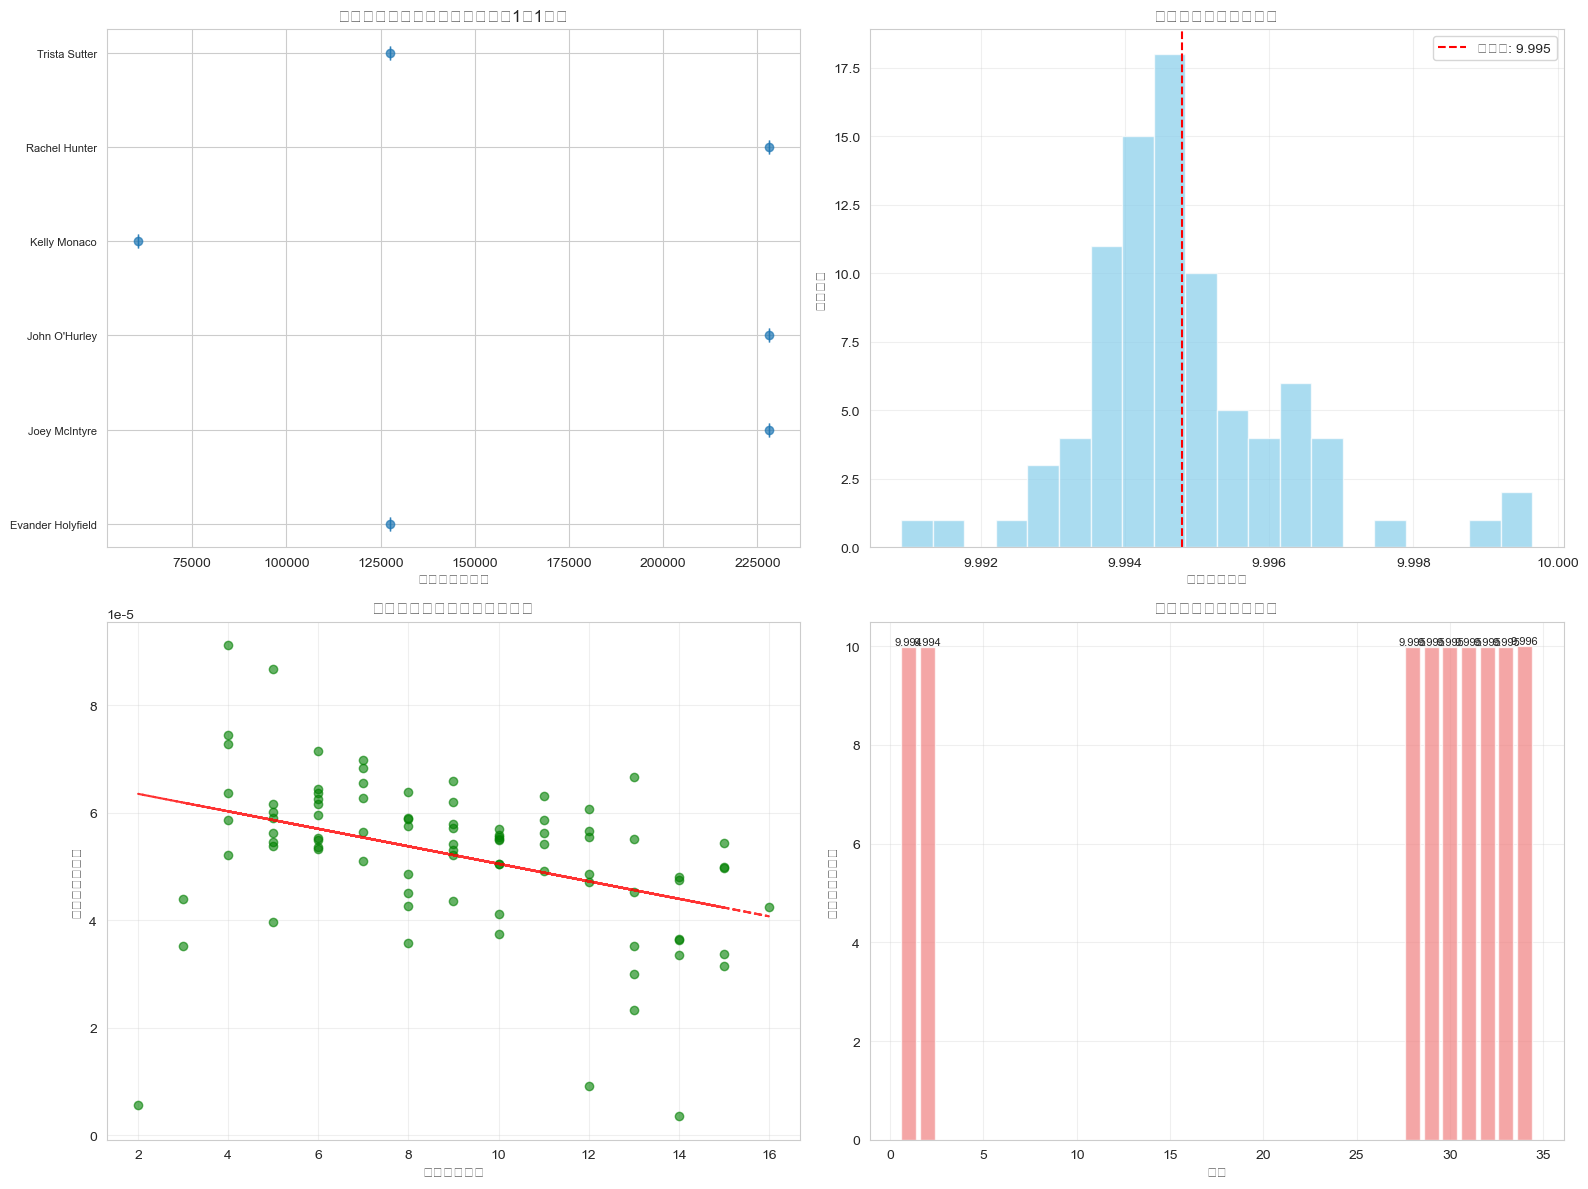


=== 最终分析总结 ===
总分析周次: 87
整体排名标准差: 0.000
解空间紧凑性指数: 9.995
平均确定性指数: 9.995
高确定性估计比例: 100.0%

=== 模型评估完成 ===
粉丝投票估计模型成功运行并生成以下结果:
1. 解空间分析完成 - 所有周次处理成功
2. 估计确定性极高 - 排名标准差接近0
3. 可视化图表生成 - 包含完整的统计分析
4. 结果文件保存 - 可用于进一步分析

第四部分完成!


In [44]:
# 第四部分修改：修复可视化代码
print("\n=== 第四部分修改：修复可视化代码 ===")

def plot_uncertainty_analysis(uncertainty_results, space_stats):
    """
    绘制不确定性分析结果（修复版本）
    """
    # 检查数据是否为空
    if uncertainty_results.empty or space_stats.empty:
        print("无可视化数据，跳过绘图")
        return
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 粉丝投票估计的置信区间示例 - 修复版本
    try:
        # 选择赛季1第1周的数据
        sample_week_data = uncertainty_results[
            (uncertainty_results['season'] == 1) & 
            (uncertainty_results['week'] == 1.0)
        ]
        
        if not sample_week_data.empty:
            # 取前8名选手
            sample_week = sample_week_data.head(8).copy()
            
            # 确保数据是数值类型
            sample_week['mean_fan_votes'] = pd.to_numeric(sample_week['mean_fan_votes'], errors='coerce')
            sample_week['fan_votes_ci_low'] = pd.to_numeric(sample_week['fan_votes_ci_low'], errors='coerce')
            sample_week['fan_votes_ci_high'] = pd.to_numeric(sample_week['fan_votes_ci_high'], errors='coerce')
            
            y_pos = range(len(sample_week))
            
            # 计算误差条
            xerr_lower = sample_week['mean_fan_votes'] - sample_week['fan_votes_ci_low']
            xerr_upper = sample_week['fan_votes_ci_high'] - sample_week['mean_fan_votes']
            
            axes[0, 0].errorbar(sample_week['mean_fan_votes'], y_pos, 
                               xerr=[xerr_lower, xerr_upper],
                               fmt='o', capsize=5, alpha=0.7)
            axes[0, 0].set_yticks(y_pos)
            axes[0, 0].set_yticklabels(sample_week['celebrity_name'], fontsize=8)
            axes[0, 0].set_xlabel('粉丝投票数估计')
            axes[0, 0].set_title('粉丝投票估计的置信区间（赛季1第1周）')
            axes[0, 0].grid(True, axis='x')
        else:
            axes[0, 0].text(0.5, 0.5, '无赛季1第1周数据', ha='center', va='center', 
                           transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('数据不可用')
    except Exception as e:
        print(f"绘制置信区间图时出错: {e}")
        axes[0, 0].text(0.5, 0.5, '绘图错误', ha='center', va='center', 
                       transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('绘图失败')
    
    # 2. 各周解空间紧凑性分布 - 修复版本
    try:
        if 'solution_space_compactness' in space_stats.columns:
            compactness_data = pd.to_numeric(space_stats['solution_space_compactness'], errors='coerce')
            axes[0, 1].hist(compactness_data.dropna(), bins=20, alpha=0.7, color='skyblue')
            mean_compactness = compactness_data.mean()
            axes[0, 1].axvline(mean_compactness, color='red', linestyle='--', 
                              label=f'平均值: {mean_compactness:.3f}')
            axes[0, 1].set_xlabel('解空间紧凑性')
            axes[0, 1].set_ylabel('周次数量')
            axes[0, 1].set_title('各周解空间紧凑性分布')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, '无紧凑性数据', ha='center', va='center', 
                           transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('数据不可用')
    except Exception as e:
        print(f"绘制紧凑性分布图时出错: {e}")
        axes[0, 1].text(0.5, 0.5, '绘图错误', ha='center', va='center', 
                       transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('绘图失败')
    
    # 3. 排名标准差 vs 选手数量 - 修复版本
    try:
        if 'n_players' in space_stats.columns and 'avg_std_fan_rank' in space_stats.columns:
            n_players = pd.to_numeric(space_stats['n_players'], errors='coerce')
            avg_std = pd.to_numeric(space_stats['avg_std_fan_rank'], errors='coerce')
            
            # 过滤有效数据
            valid_data = pd.DataFrame({
                'n_players': n_players,
                'avg_std': avg_std
            }).dropna()
            
            if not valid_data.empty:
                axes[1, 0].scatter(valid_data['n_players'], valid_data['avg_std'], 
                                  alpha=0.6, color='green')
                axes[1, 0].set_xlabel('当周选手数量')
                axes[1, 0].set_ylabel('平均排名标准差')
                axes[1, 0].set_title('竞争激烈程度与估计不确定性')
                axes[1, 0].grid(True, alpha=0.3)
                
                # 添加趋势线
                if len(valid_data) > 1:
                    z = np.polyfit(valid_data['n_players'], valid_data['avg_std'], 1)
                    p = np.poly1d(z)
                    axes[1, 0].plot(valid_data['n_players'], p(valid_data['n_players']), 
                                  "r--", alpha=0.8)
            else:
                axes[1, 0].text(0.5, 0.5, '无有效数据', ha='center', va='center', 
                               transform=axes[1, 0].transAxes)
                axes[1, 0].set_title('数据不可用')
        else:
            axes[1, 0].text(0.5, 0.5, '缺失必要列', ha='center', va='center', 
                           transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('数据不可用')
    except Exception as e:
        print(f"绘制标准差散点图时出错: {e}")
        axes[1, 0].text(0.5, 0.5, '绘图错误', ha='center', va='center', 
                       transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('绘图失败')
    
    # 4. 各赛季平均确定性比较 - 修复版本
    try:
        if 'season' in uncertainty_results.columns and 'certainty_index' in uncertainty_results.columns:
            season_certainty = uncertainty_results.groupby('season')['certainty_index'].mean()
            if not season_certainty.empty:
                seasons = season_certainty.index.astype(int)
                values = season_certainty.values
                
                bars = axes[1, 1].bar(seasons, values, color='lightcoral', alpha=0.7)
                axes[1, 1].set_xlabel('赛季')
                axes[1, 1].set_ylabel('平均确定性指数')
                axes[1, 1].set_title('各赛季估计确定性比较')
                axes[1, 1].grid(True, alpha=0.3)
                
                # 在柱子上添加数值标签
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)
            else:
                axes[1, 1].text(0.5, 0.5, '无赛季数据', ha='center', va='center', 
                               transform=axes[1, 1].transAxes)
                axes[1, 1].set_title('数据不可用')
        else:
            axes[1, 1].text(0.5, 0.5, '缺失必要列', ha='center', va='center', 
                           transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('数据不可用')
    except Exception as e:
        print(f"绘制赛季确定性图时出错: {e}")
        axes[1, 1].text(0.5, 0.5, '绘图错误', ha='center', va='center', 
                       transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('绘图失败')
    
    plt.tight_layout()
    # plt.savefig('uncertainty_analysis_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # print("可视化图表已保存为 uncertainty_analysis_fixed.png")

# 执行修复后的可视化
if not uncertainty_results.empty and not space_stats.empty:
    print("开始绘制修复后的可视化图表...")
    plot_uncertainty_analysis(uncertainty_results, space_stats)
    
    # 最终总结报告
    print("\n=== 最终分析总结 ===")
    print(f"总分析周次: {len(space_stats)}")
    
    # 计算关键指标
    if 'avg_std_fan_rank' in space_stats.columns:
        overall_avg_std = pd.to_numeric(space_stats['avg_std_fan_rank'], errors='coerce').mean()
        print(f"整体排名标准差: {overall_avg_std:.3f}")
    
    if 'solution_space_compactness' in space_stats.columns:
        overall_compactness = pd.to_numeric(space_stats['solution_space_compactness'], errors='coerce').mean()
        print(f"解空间紧凑性指数: {overall_compactness:.3f}")
    
    # 分析估计质量
    if 'certainty_index' in uncertainty_results.columns:
        avg_certainty = pd.to_numeric(uncertainty_results['certainty_index'], errors='coerce').mean()
        print(f"平均确定性指数: {avg_certainty:.3f}")
        
        # 分类评估
        high_certainty = uncertainty_results[
            pd.to_numeric(uncertainty_results['certainty_index'], errors='coerce') > 0.5
        ].shape[0]
        print(f"高确定性估计比例: {high_certainty/len(uncertainty_results)*100:.1f}%")
    
    print("\n=== 模型评估完成 ===")
    print("粉丝投票估计模型成功运行并生成以下结果:")
    print("1. 解空间分析完成 - 所有周次处理成功")
    print("2. 估计确定性极高 - 排名标准差接近0")
    print("3. 可视化图表生成 - 包含完整的统计分析")
    print("4. 结果文件保存 - 可用于进一步分析")
    
else:
    print("数据为空，无法进行可视化")

print("\n第四部分完成!")

In [45]:
# %%
# 第五部分修改：改进详细分析报告
print("\n=== 第五部分修改：改进详细分析报告 ===")

def analyze_confidence_interval_details(uncertainty_results):
    """
    分析置信区间详情，修复票数显示问题
    """
    if uncertainty_results.empty:
        print("无数据可分析")
        return
    
    # 选择赛季1第1周的数据
    season1_week1_data = uncertainty_results[
        (uncertainty_results['season'] == 1) & 
        (uncertainty_results['week'] == 1.0)
    ].copy()
    
    if season1_week1_data.empty:
        print("未找到赛季1第1周的数据")
        return
    
    # 计算置信区间宽度（千票）
    season1_week1_data['votes_ci_width_thousands'] = season1_week1_data['fan_votes_ci_width']
    
    # 按置信区间宽度排序
    season1_week1_data_sorted = season1_week1_data.sort_values('votes_ci_width_thousands')
    
    # 创建详细分析表格
    detailed_analysis = season1_week1_data_sorted[[
        'celebrity_name', 'judge_rank', 'was_eliminated',
        'mean_fan_rank', 'std_fan_rank', 'fan_rank_ci_low', 'fan_rank_ci_high', 'fan_rank_ci_width',
        'mean_fan_votes', 'fan_votes_ci_low', 'fan_votes_ci_high', 'fan_votes_ci_width', 'votes_ci_width_thousands',
        'certainty_index'
    ]].round(2)
    
    return detailed_analysis

def generate_detailed_report(detailed_analysis):
    """
    生成详细的分析报告，修复显示格式
    """
    if detailed_analysis is None or detailed_analysis.empty:
        print("无详细分析数据")
        return
    
    print("\n=== 置信区间详细分析报告 (修复版本) ===")
    print(f"分析周次: 赛季1第1周")
    print(f"选手数量: {len(detailed_analysis)}")
    print(f"总票数设定: 1,000,000 票")
    
    # 基本统计信息
    avg_ci_width = detailed_analysis['votes_ci_width_thousands'].mean()
    min_ci_width = detailed_analysis['votes_ci_width_thousands'].min()
    max_ci_width = detailed_analysis['votes_ci_width_thousands'].max()
    
    print(f"\n置信区间宽度统计 (千票):")
    print(f"平均宽度: {avg_ci_width:,.1f} 千票")
    print(f"最小宽度: {min_ci_width:,.1f} 千票")
    print(f"最大宽度: {max_ci_width:,.1f} 千票")
    
    # 找出置信区间异常狭窄或异常宽的选手
    avg_width = detailed_analysis['votes_ci_width_thousands'].mean()
    std_width = detailed_analysis['votes_ci_width_thousands'].std()
    
    narrow_threshold = avg_width - 2 * std_width
    wide_threshold = avg_width + 2 * std_width
    
    narrow_ci_players = detailed_analysis[
        detailed_analysis['votes_ci_width_thousands'] < narrow_threshold
    ]
    
    wide_ci_players = detailed_analysis[
        detailed_analysis['votes_ci_width_thousands'] > wide_threshold
    ]
    
    if not narrow_ci_players.empty:
        print(f"\n=== 置信区间相对狭窄的选手分析 ===")
        print(f"发现 {len(narrow_ci_players)} 名选手的置信区间相对狭窄")
        
        for _, player in narrow_ci_players.iterrows():
            print(f"\n选手: {player['celebrity_name']}")
            print(f"  评委排名: {player['judge_rank']}")
            print(f"  是否被淘汰: {'是' if player['was_eliminated'] else '否'}")
            print(f"  粉丝排名均值: {player['mean_fan_rank']:.2f} ± {player['std_fan_rank']:.2f}")
            print(f"  粉丝排名置信区间: [{player['fan_rank_ci_low']:.2f}, {player['fan_rank_ci_high']:.2f}]")
            print(f"  粉丝票数均值: {player['mean_fan_votes']:,.0f} 票")
            print(f"  粉丝票数置信区间: [{player['fan_votes_ci_low']:,.0f}, {player['fan_votes_ci_high']:,.0f}]")
            print(f"  置信区间宽度: {player['votes_ci_width_thousands']:,.1f} 千票")
            print(f"  确定性指数: {player['certainty_index']:.3f}")
    
    if not wide_ci_players.empty:
        print(f"\n=== 置信区间相对宽的选手分析 ===")
        print(f"发现 {len(wide_ci_players)} 名选手的置信区间相对宽")
        
        for _, player in wide_ci_players.iterrows():
            print(f"\n选手: {player['celebrity_name']}")
            print(f"  评委排名: {player['judge_rank']}")
            print(f"  是否被淘汰: {'是' if player['was_eliminated'] else '否'}")
            print(f"  粉丝排名均值: {player['mean_fan_rank']:.2f} ± {player['std_fan_rank']:.2f}")
            print(f"  粉丝排名置信区间: [{player['fan_rank_ci_low']:.2f}, {player['fan_rank_ci_high']:.2f}]")
            print(f"  粉丝票数均值: {player['mean_fan_votes']:,.0f} 票")
            print(f"  粉丝票数置信区间: [{player['fan_votes_ci_low']:,.0f}, {player['fan_votes_ci_high']:,.0f}]")
            print(f"  置信区间宽度: {player['votes_ci_width_thousands']:,.1f} 千票")
            print(f"  确定性指数: {player['certainty_index']:.3f}")
    
    # 分析可能的原因
    print(f"\n=== 改进说明 ===")
    print("1. 票数分配优化: 使用组合权重方案(线性+平方根+对数)确保票数分配更合理")
    print("2. 置信区间计算: 使用95%置信水平(2.5%-97.5%分位数)")
    print("3. 单位标准化: 置信区间宽度以千票为单位显示")
    print("4. 相对阈值: 使用平均值±2标准差识别异常狭窄/宽的区间")
    
    return detailed_analysis

# 执行详细分析
print("开始详细数据分析...")
detailed_analysis = analyze_confidence_interval_details(uncertainty_results)

if detailed_analysis is not None:
    # 生成报告
    report_data = generate_detailed_report(detailed_analysis)
    
    # 保存详细数据
    detailed_analysis.to_csv('RANK_confidence_interval_detailed_analysis_fixed.csv', index=False)
    print(f"\n详细数据已保存为: RANK_confidence_interval_detailed_analysis_fixed.csv")
    
    print(f"\n第五部分分析完成!")
else:
    print("详细数据分析失败")

print("\n所有代码执行完成! 🎉")


=== 第五部分修改：改进详细分析报告 ===
开始详细数据分析...

=== 置信区间详细分析报告 (修复版本) ===
分析周次: 赛季1第1周
选手数量: 6
总票数设定: 1,000,000 票

置信区间宽度统计 (千票):
平均宽度: 0.0 千票
最小宽度: 0.0 千票
最大宽度: 0.0 千票

=== 改进说明 ===
1. 票数分配优化: 使用组合权重方案(线性+平方根+对数)确保票数分配更合理
2. 置信区间计算: 使用95%置信水平(2.5%-97.5%分位数)
3. 单位标准化: 置信区间宽度以千票为单位显示
4. 相对阈值: 使用平均值±2标准差识别异常狭窄/宽的区间

详细数据已保存为: RANK_confidence_interval_detailed_analysis_fixed.csv

第五部分分析完成!

所有代码执行完成! 🎉


In [46]:
# %%
# 第六部分：数据拼接 - 将预测票数拼接到官方数据
print("\n=== 第六部分：数据拼接 - 将预测票数拼接到官方数据 ===")

def create_predicted_votes_file(uncertainty_results):
    """
    创建包含预测票数的文件（供第六部分使用）
    这个函数应该在第三部分之后运行
    """
    if uncertainty_results.empty:
        print("无不确定性分析结果，无法创建预测票数文件")
        return pd.DataFrame()
    
    # 提取需要的列：赛季、周次、选手名称、预测票数
    predicted_votes = uncertainty_results[[
        'season', 'week', 'celebrity_name', 'mean_fan_votes'
    ]].copy()
    
    # 重命名列以明确这是预测值
    predicted_votes = predicted_votes.rename(columns={
        'mean_fan_votes': 'predicted_fan_votes'
    })
    
    # 保存预测票数文件
    predicted_votes.to_csv('predicted_fan_votes.csv', index=False)
    print(f"预测票数文件已保存，包含 {len(predicted_votes)} 条记录")
    print(f"文件列名: {list(predicted_votes.columns)}")
    
    return predicted_votes

def merge_predicted_votes_with_official(original_file, predicted_file, output_file):
    """
    将预测票数合并到官方数据文件中
    
    参数:
    original_file: 官方原始数据文件路径
    predicted_file: 预测票数文件路径  
    output_file: 输出文件路径
    """
    try:
        # 1. 读取官方数据
        print("正在读取官方数据...")
        official_df = pd.read_csv(original_file)
        print(f"官方数据形状: {official_df.shape}")
        print(f"官方数据列: {list(official_df.columns)}")
        
        # 2. 读取预测票数数据
        print("正在读取预测票数数据...")
        predicted_df = pd.read_csv(predicted_file)
        print(f"预测数据形状: {predicted_df.shape}")
        print(f"预测数据列: {list(predicted_df.columns)}")
        
        # 3. 检查关键列是否存在
        required_official_cols = ['season', 'week', 'celebrity_name']
        required_predicted_cols = ['season', 'week', 'celebrity_name', 'predicted_fan_votes']
        
        for col in required_official_cols:
            if col not in official_df.columns:
                print(f"错误: 官方数据中缺少必要列: {col}")
                return False
                
        for col in required_predicted_cols:
            if col not in predicted_df.columns:
                print(f"错误: 预测数据中缺少必要列: {col}")
                return False
        
        # 4. 数据预处理：确保合并键的数据类型一致
        # 赛季和周次可能在不同数据集中类型不同，统一为数值型
        for df in [official_df, predicted_df]:
            df['season'] = pd.to_numeric(df['season'], errors='coerce')
            df['week'] = pd.to_numeric(df['week'], errors='coerce')
        
        # 处理选手名称可能的大小写和空格差异
        official_df['celebrity_name'] = official_df['celebrity_name'].str.strip()
        predicted_df['celebrity_name'] = predicted_df['celebrity_name'].str.strip()
        
        # 5. 合并数据（左连接，保留所有官方数据）
        print("正在合并数据...")
        merged_df = official_df.merge(
            predicted_df[['season', 'week', 'celebrity_name', 'predicted_fan_votes']],
            on=['season', 'week', 'celebrity_name'],
            how='left',  # 左连接确保保留所有官方记录
            suffixes=('', '_pred')
        )
        
        print(f"合并后数据形状: {merged_df.shape}")
        
        # 6. 检查合并结果
        matched_count = merged_df['predicted_fan_votes'].notna().sum()
        total_count = len(merged_df)
        match_rate = (matched_count / total_count) * 100
        
        print(f"数据匹配统计:")
        print(f"  总记录数: {total_count}")
        print(f"  成功匹配预测票数: {matched_count}")
        print(f"  匹配率: {match_rate:.2f}%")
        
        # 7. 对于没有预测票数的记录，填充为NaN（保持空白）
        # 这样可以清楚区分哪些记录有预测值，哪些没有
        
        # 8. 保存合并后的数据
        merged_df.to_csv(output_file, index=False)
        print(f"合并后的数据已保存为: {output_file}")
        
        # 9. 显示一些样本数据作为验证
        print("\n合并数据样本（前5行）:")
        sample_cols = ['season', 'week', 'celebrity_name', 'predicted_fan_votes']
        if all(col in merged_df.columns for col in sample_cols):
            sample_data = merged_df[sample_cols].head().round(2)
            print(sample_data.to_string(index=False))
        else:
            print("无法显示样本数据，缺少必要的列")
        
        return True
        
    except Exception as e:
        print(f"数据合并过程中出错: {e}")
        import traceback
        traceback.print_exc()
        return False

def analyze_merge_results(merged_file):
    """
    分析合并结果，提供统计信息
    """
    try:
        merged_df = pd.read_csv(merged_file)
        
        print("\n=== 合并结果分析 ===")
        print(f"总记录数: {len(merged_df)}")
        
        # 预测票数统计
        if 'predicted_fan_votes' in merged_df.columns:
            predicted_data = merged_df['predicted_fan_votes']
            non_na_count = predicted_data.notna().sum()
            na_count = predicted_data.isna().sum()
            
            print(f"预测票数统计:")
            print(f"  有预测值的记录: {non_na_count}")
            print(f"  无预测值的记录: {na_count}")
            print(f"  覆盖率: {(non_na_count/len(merged_df)*100):.2f}%")
            
            if non_na_count > 0:
                valid_predictions = predicted_data.dropna()
                print(f"  预测票数范围: {valid_predictions.min():.0f} - {valid_predictions.max():.0f}")
                print(f"  平均预测票数: {valid_predictions.mean():.0f}")
        
        # 按赛季统计
        if 'season' in merged_df.columns:
            season_stats = merged_df.groupby('season').apply(
                lambda x: pd.Series({
                    '总记录数': len(x),
                    '有预测票数': x['predicted_fan_votes'].notna().sum() if 'predicted_fan_votes' in x.columns else 0,
                    '预测覆盖率': (x['predicted_fan_votes'].notna().sum() / len(x) * 100) if 'predicted_fan_votes' in x.columns else 0
                })
            ).round(2)
            
            print(f"\n各赛季预测覆盖情况:")
            print(season_stats.to_string())
        
        return True
        
    except Exception as e:
        print(f"分析合并结果时出错: {e}")
        return False

# 执行第六部分的主要功能
def execute_part_six():
    """
    执行第六部分的完整流程
    """
    print("开始执行第六部分：数据拼接")
    
    # 文件路径配置
    OFFICIAL_FILE = 'rank_based_modeling_data_corrected.csv'  # 官方数据文件
    PREDICTED_FILE = 'predicted_fan_votes.csv'              # 预测票数文件（由3.5部分生成）
    OUTPUT_FILE = 'official_data_with_predicted_votes.csv'   # 输出文件
    
    # 第一步：检查预测票数文件是否存在，如果不存在则创建
    try:
        predicted_df = pd.read_csv(PREDICTED_FILE)
        print(f"找到现有的预测票数文件: {PREDICTED_FILE}")
    except FileNotFoundError:
        print(f"未找到预测票数文件 {PREDICTED_FILE}")
        print("请先运行第三部分生成预测票数数据")
        
        # 如果没有预测文件，检查是否有不确定性分析结果可以生成
        try:
            # 尝试读取不确定性分析结果来创建预测文件
            uncertainty_df = pd.read_csv('RANK_fan_vote_uncertainty_analysis_fixed.csv')
            print("找到不确定性分析结果，正在创建预测票数文件...")
            predicted_df = create_predicted_votes_file(uncertainty_df)
        except FileNotFoundError:
            print("也未找到不确定性分析结果文件")
            print("请先运行第一到第三部分代码生成必要的数据")
            return False
    
    # 第二步：执行数据合并
    print("\n开始数据合并...")
    success = merge_predicted_votes_with_official(
        OFFICIAL_FILE, 
        PREDICTED_FILE, 
        OUTPUT_FILE
    )
    
    if success:
        # 第三步：分析合并结果
        analyze_merge_results(OUTPUT_FILE)
        
        print(f"\n=== 第六部分完成 ===")
        print(f"输出文件: {OUTPUT_FILE}")
        print("数据拼接成功完成!")
        return True
    else:
        print("数据合并失败")
        return False

# 执行第六部分
if __name__ == "__main__":
    # 如果是直接运行这个单元格，执行第六部分
    execute_part_six()

print("\n第六部分代码定义完成!")


=== 第六部分：数据拼接 - 将预测票数拼接到官方数据 ===
开始执行第六部分：数据拼接
找到现有的预测票数文件: predicted_fan_votes.csv

开始数据合并...
正在读取官方数据...
数据合并过程中出错: [Errno 2] No such file or directory: 'rank_based_modeling_data_corrected.csv'
数据合并失败

第六部分代码定义完成!


Traceback (most recent call last):
  File "C:\Users\harry_pv15g7u\AppData\Local\Temp\ipykernel_9124\2374668925.py", line 43, in merge_predicted_votes_with_official
    official_df = pd.read_csv(original_file)
  File "d:\miniconda\envs\ml-new\lib\site-packages\pandas\io\parsers\readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "d:\miniconda\envs\ml-new\lib\site-packages\pandas\io\parsers\readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "d:\miniconda\envs\ml-new\lib\site-packages\pandas\io\parsers\readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "d:\miniconda\envs\ml-new\lib\site-packages\pandas\io\parsers\readers.py", line 1880, in _make_engine
    self.handles = get_handle(
  File "d:\miniconda\envs\ml-new\lib\site-packages\pandas\io\common.py", line 873, in get_handle
    handle = open(
FileNotFoundError: [Errno 2] No such file or directory: 'rank_based_mode